# an emission spectrum  check CO



In [1]:
#
#   Current Status: Feb. 12th (2021)
#
#   OK: forward JVP / HML RT alpha as a free parameter
#   Not work: primitive backward / alpha as a free parameter
#   Not implemented yet: VJP backward (something wrong for NumPyro) 
#
#   Current fiducial model: forward JVP
#   Updates:   planck nB (Feb.12/2021)
#
#   ToDo:
#   Q(T)
# 

In [2]:
# importing lpf modile in exojax.spec
%load_ext autoreload
%autoreload 2
from exojax.spec import rtransfer as rt
from exojax.spec import planck
from exojax.spec import moldb
from exojax.spec import make_numatrix0,xsvector
from exojax.spec.lpf import xsmatrix
from exojax.spec.clpf import cxsmatrix
from exojax.spec.hitran import SijT, doppler_sigma, gamma_hitran, gamma_natural
from exojax.plot.atmplot import plottau, plotcf
import numpy as np
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from petitRADTRANS import Radtrans
import petitRADTRANS.nat_cst as nc

/home/kawahara/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import jax.numpy as jnp
from jax import random
from jax.lax import map, scan
from jax import vmap, jit
plt.style.use('bmh')

In [4]:
dat=pd.read_csv("co/Gl229/Gl229B_spectrum_CO.dat",delimiter=" ",names=("WAV","VAL"))

In [5]:
1.e8/(np.max(dat["WAV"])*10000),1.e8/(np.min(dat["WAV"])*10000)

(4166.664930556279, 4385.966835950367)

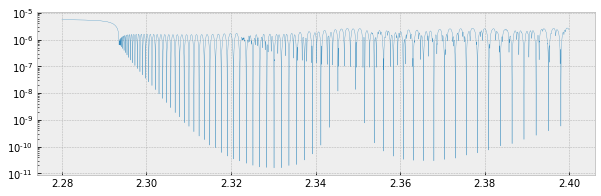

In [6]:
#wav[um], Flux[erg/cm2/s/Hz]
fig=plt.figure(figsize=(10,3))
plt.plot(dat["WAV"],dat["VAL"],lw=0.3)
plt.yscale("log")

## INPUT MODEL

In [7]:
# TP
#pressures = np.logspace(-10, 2, 130)
NP=130
#Parr, dParr, k=rt.pressure_layer(logPtop=-10.,logPbtm=2.,NP=NP)

R_pl = 1.838*nc.r_jup_mean
gravity = 1e1**5.0
P0 = 0.01

kappa_IR = 0.01
gamma = 0.4
T_int = 200.
T_equ = 1500.
#Tarr = nc.guillot_global(Parr, kappa_IR, gamma, gravity, T_int, T_equ)
#Tarr = 1500.*(Parr/Parr[-1])**alpha_in

In [8]:
#Parr, dParr, k=rt.pressure_layer(logPtop=-10.,logPbtm=2.,NP=NP)
#
#print(Parr[1]-Parr[0],dParr[1])
#print(Parr[2]-Parr[1],dParr[2])

In [9]:
N=100000
wav=np.linspace(23000.0,24000.0,N,dtype=np.float64)#AA
nus=1.e8/wav[::-1]

#loading molecular database (HITRAN2012/CO)
#mdbCO=moldb.MdbHit('/home/kawahara/exojax/data/CO/05_hit12.par',nus)

mdbCO=moldb.MdbHit('/home/kawahara/exojax/data/hitemp/CO/05_HITEMP2019.par',nus)
print("read end")

read end


In [10]:
nus[1]-nus[0]

0.001736129195705871

In [11]:
np.min(1.e8/mdbCO.nu_lines),np.max(1.e8/mdbCO.nu_lines)

(21749.546202623962, 25531.77204606857)

In [12]:
NP=130
Nspecies=160
Parr=np.ones(NP)
Tarr=np.ones(NP)

### read header
data = open('co/Gl229/MMR/eq.dat', 'r')
line = data.read().split()
data.close()
molname = {}
for a in range(0,160):
    molname[a] = line[a+6]

data = open('co/Gl229/MMR/eq.dat', 'r')
a = 0
MMW_k = np.ones_like(Tarr)
MMR = np.zeros((Nspecies,NP))
for line in data:
    if line[0]=='#':
        continue
    lines = line.rstrip('\n').split()
    Parr[a] = lines[0]
    Tarr[a] = lines[1]
    MMW_k[a] = lines[2]
    for i in range(0,160):
        MMR[i,a] = lines[i+3]
    a = a + 1
data.close()

Tarr=jnp.array(Tarr)
Parr=jnp.array(Parr)


In [13]:
dParr=np.zeros_like(Parr)
for i in range(1,len(Parr)):
    dParr[i] = Parr[i]-Parr[i-1]
dParr[0]=dParr[1]

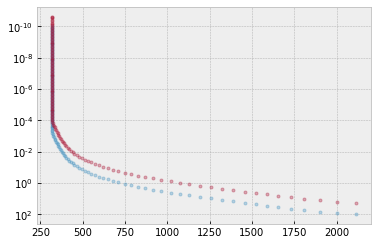

In [14]:
plt.plot(Tarr,Parr,".",alpha=0.3)
plt.plot(Tarr,dParr,".",alpha=0.3)
plt.yscale("log")
#plt.xscale("log")
plt.gca().invert_yaxis()

In [15]:
#partition function ratio
#CHEATING NOW
#mdbCO_HITRAN=moldb.MdbHit('/home/kawahara/exojax/data/CO','05_hit12',nus)
mdbCO_hitran=moldb.MdbHit('/home/kawahara/exojax/data/CO/05_hit12.par',nus)
qr=mdbCO_hitran.Qr(Tarr)

In [16]:
np.shape(qr) #Tlayer, iso

(130, 6)

In [17]:
#partitioning Q(T) for each line
qt=np.zeros((NP,len(mdbCO.isoid)))
for idx,iso in enumerate(mdbCO.uniqiso):
    mask=mdbCO.isoid==iso
    for ilayer in range(NP):
        qt[ilayer,mask]=qr[ilayer,idx]

In [18]:
np.shape(qt),np.shape(mdbCO.A)

((130, 30876), (30876,))

In [19]:
np.mean(MMW_k), np.mean(MMR[26]), molname[26]

(2.362215817735385, 0.0002755907825333655, 'C1O1')

In [20]:
np.shape(qt),np.shape(mdbCO.A)

((130, 30876), (30876,))

In [21]:
#Mmol=28.010446441149536
Mmol=2.33 #mean molecular weight

Tref=296.0
SijM=vmap(SijT,(0,None,None,None,0))(Tarr,mdbCO.logsij0,mdbCO.nu_lines\
                                          ,mdbCO.elower,qt)
gammaLM = vmap(gamma_hitran,(0,0,0,None,None,None))\
(Parr,Tarr,Parr, mdbCO.n_air, mdbCO.gamma_air, mdbCO.gamma_self)
+ gamma_natural(mdbCO.A) #uncomment if you inclide a natural width
sigmaDM=vmap(doppler_sigma,(None,0,None))(mdbCO.nu_lines,Tarr,Mmol)

In [22]:
#numatrix0=make_numatrix0(nus,mdbCH4.nu_lines)
#xsmatrix=jit(vmap(xsvector,(None,0,0,0)))

In [23]:

nu0=mdbCO.nu_lines
memory_size=15.0

d=int(memory_size/(len(nu0)*4/1024./1024.))
Ni=int(len(nus)/d)

d2=100
Nlayer=np.shape(SijM)[0]
Nline=np.shape(SijM)[1]
Nj=int(Nline/d2)
xsm=[]
for i in tqdm.tqdm(range(0,Ni+1)):
    s=int(i*d);e=int((i+1)*d);e=min(e,len(nus))
    xsmtmp=np.zeros((Nlayer,e-s))
    #line 
    for j in range(0,Nj+1):
        s2=int(j*d2);e2=int((j+1)*d2);e2=min(e2,Nline)
        numatrix=make_numatrix0(nus[s:e],nu0[s2:e2])
        xsmtmp=xsmtmp+\
        xsmatrix(numatrix,sigmaDM[:,s2:e2],gammaLM[:,s2:e2],SijM[:,s2:e2])
    if i==0:
        xsm=np.copy(xsmtmp.T)
    else:
        xsm = np.concatenate([xsm,xsmtmp.T])
xsm=xsm.T



100%|██████████| 788/788 [11:23<00:00,  1.37s/it]


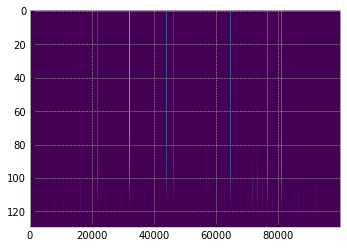

In [24]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.imshow(xsm)
ax.set_aspect(0.7/ax.get_data_ratio())

In [25]:
from scipy.constants import  m_u

In [26]:
#piB(Tarr[0],np.mean(nus))/piB(Tarr[-1],np.mean(nus))

In [27]:
from exojax.spec.planck import nB

In [28]:
1.e4/np.mean(nus)

2.3496453401588875

In [29]:
np.mean(nus)

4255.96145472907

In [30]:
nB(Tarr[0],1/1.6389949141334232)/nB(Tarr[-1],1/1.6389949141334232)

DeviceArray(5.87217e-11, dtype=float32)

In [31]:
from scipy.constants import Boltzmann, proton_mass, speed_of_light, Planck
Planck*speed_of_light*1.e2/Boltzmann 

1.4387773538277202

In [32]:
@jit
def piB(T,nus):
    """pi B (Planck Function)                                               
                                                                                
    Args:                                                                       
       T: temperature [K]                                                       
       nus: wavenumber [cm-1]                          
                                                                                
    Returns:                                                                    
           piB: pi B                                                           
           
    """
    hcperk=1.4387773538277202
    fac=3.741771790075259e-05
    return (fac*nus**3)/(jnp.exp(hcperk*nus/T)-1.0)

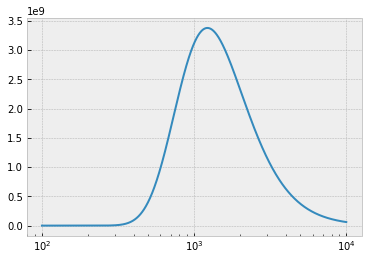

In [33]:
w=jnp.logspace(2,4,1000) #nm
nu=1.e7/w
plt.plot(w,nu*piB(3000.,nu))
#plt.yscale("log")
plt.xscale("log")

In [34]:
@jit
def piBarr(T,nus):
    """pi B arr (Planck Function)                                               
                                                                                
    Args:                                                                       
       T: temperature [K]                                                       
       nus: wavenumber [cm-1]                          
                                                                                
    Returns:                                                                    
           piB: pi B                                                           
           
    """
    hcperk=1.4387773538277202
    fac=3.741771790075259e-05
    return (fac*nus**3)/(jnp.exp(hcperk*nus/T[:,None])-1.0)

In [35]:
def g(x):
    return x**3/(jnp.exp(x)-1.0)

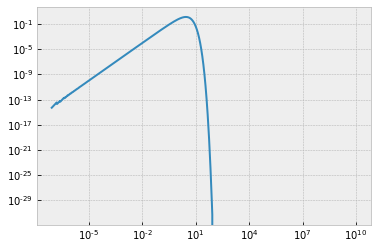

In [36]:
x=jnp.logspace(-10,10,1000)
plt.plot(x,g(x))
plt.xscale("log")
plt.yscale("log")

In [37]:
from scipy.constants import Boltzmann, proton_mass, speed_of_light, Planck

In [38]:
Planck*speed_of_light*1.e-2/Boltzmann #cm-1/K

0.00014387773538277203

In [39]:
#pi 2 h c^2 # m2kg/s m/s m/s  1.e3 (kg->g), 1.e8
2*Planck*(speed_of_light)**2*np.pi*1.e11#*(np.mean(nus)**3)

3.741771790075259e-05

In [107]:
from scipy.constants import  m_u
#1 bar = 10^5 Pa = 10^6 dyn/cm2, dyn=g cm/s2
g=5000.0 # cm/s2
#Xco= MMR[26] #mixing ratio
#Xco= np.ones_like(MMR[26])*0.001
Xco= np.ones_like(MMR[26])*0.000003
#molecular weight = Mmol*m_u*1.e3 (g)
#tfac=1.e6*Xco/(Mmol*m_u*g*1.e3)
tfac=1.e6*Xco/(Mmol*m_u*g*1.e3)  ##WARNING
nusmean=np.mean(nus)
#gi = piB(Tarr,nusmean)
gi=piBarr(Tarr,nus)

In [117]:
0.000003/0.001,(0.000003/0.001)**-1

(0.003, 333.3333333333333)

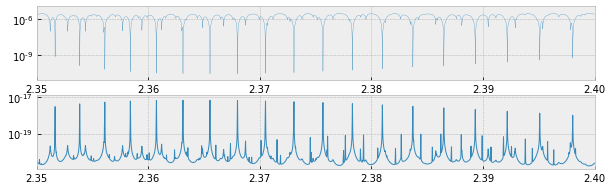

In [108]:
fig=plt.figure(figsize=(10,3))
ax=fig.add_subplot(211)
plt.plot(dat["WAV"],dat["VAL"],lw=0.3)
plt.xlim(2.35,2.40)
plt.yscale("log")
ax2=fig.add_subplot(212)
ax2.plot(1.e4/nus,np.sum(xsm,axis=0),lw=1)
plt.xlim(2.35,2.40)
plt.yscale("log")
#ax2.set_aspect(0.7/ax2.get_data_ratio())

In [109]:
@jit
def rtFe(xsm):
    dtauM=dParr[:,None]*xsm*tfac[:,None]
    TransMx=(1.0-dtauM)*jnp.exp(-dtauM)
    TransM=jnp.where(dtauM==0, 1.0, TransMx)   
    QN=jnp.zeros(len(nus))
    Qv=(1-TransM)*gi
    
    Qv=jnp.vstack([Qv,QN])
    onev=jnp.ones(len(nus))
    TransM=jnp.vstack([onev,TransM])
    Fx=(jnp.sum(Qv*jnp.cumprod(TransM,axis=0),axis=0))
    return Fx,dtauM

In [110]:
@jit
def rtF(xsm):
    A0=-0.57721566
    A1= 0.99999193
    A2=-0.24991055
    A3= 0.05519968
    A4=-0.00976004
    A5= 0.00107857
    B1=8.5733287401
    B2=18.059016973
    B3=8.6347608925
    B4=0.2677737343
    C1=9.5733223454
    C2=25.6329561486
    C3=21.0996530827
    C4=3.9584969228
    
    dtauM=dParr[:,None]*xsm*tfac[:,None]
    dtauM2=dtauM**2
    dtauM3=dtauM**3
    dtauM4=dtauM**4
    dtauM5=dtauM**5
    ep1A=-jnp.log(dtauM)+A0+A1*dtauM+A2*dtauM2+A3*dtauM3+A4*dtauM4+A5*dtauM5
    ep1B=jnp.exp(-dtauM)/dtauM*\
    (dtauM4+B1*dtauM3+B2*dtauM2+B3*dtauM+B4)/\
    (dtauM4+C1*dtauM3+C2*dtauM2+C3*dtauM+C4)
    ep=jnp.where(dtauM<=1.0, ep1A, ep1B)

    TransMx=(1.0-dtauM)*jnp.exp(-dtauM)+dtauM2*ep
    TransM=jnp.where(dtauM==0, 1.0, TransMx)   
    QN=jnp.zeros(len(nus))
    #Qv=(1-TransM)*gi[:,None]
    Qv=(1-TransM)*gi
    Qv=jnp.vstack([Qv,QN])
    onev=jnp.ones(len(nus))
    TransM=jnp.vstack([onev,TransM])
    Fx=(jnp.sum(Qv*jnp.cumprod(TransM,axis=0),axis=0))
    return Fx,dtauM

In [111]:
@jit
def rtFn(xsm):
    dtauM=dParr[:,None]*xsm*tfac[:,None]
    tau=jnp.cumsum(dtauM,axis=0)
    Fx=jnp.sum(gi*jnp.exp(-tau)*dtauM,axis=0)
    return Fx,dtauM

(0.0, 3e-06)

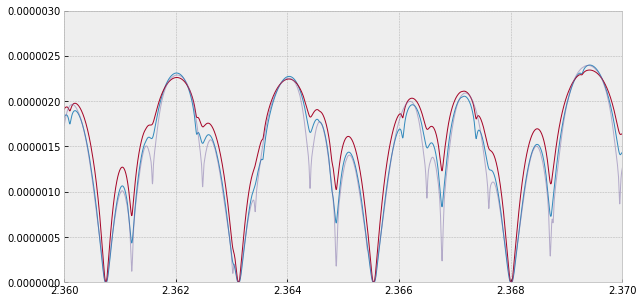

In [119]:
Fx0,dtauM=rtF(xsm)
Fx0n,dtauM=rtFn(xsm)
#Fx1=rtF(0.3)

fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)
plt.plot(1.e4/nus,Fx0/ccgs,lw=1,alpha=1)
plt.plot(1.e4/nus,Fx0n/ccgs,lw=1)
plt.plot(dat["WAV"],dat["VAL"],lw=1,alpha=0.5)
#plt.xlim(1.634,1.644)
plt.xlim(2.36,2.37)
#plt.xlim(2.35,2.39)
#ax.set_aspect(0.6/ax.get_data_ratio())
#plt.yscale("log")
plt.ylim(0.0,3.e-6)

In [113]:
Fx0,dtauM=rtFn(xsm)
#Fx1=rtF(0.3)

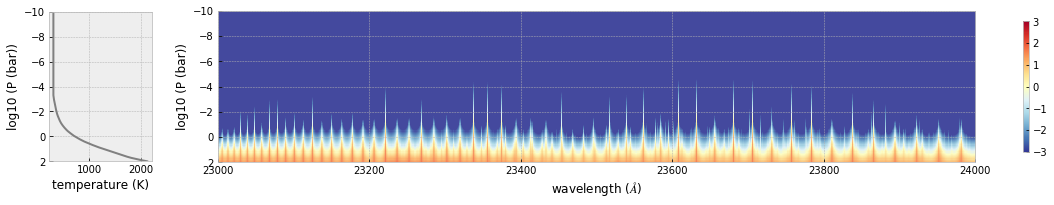

In [49]:
plottau(nus,dtauM,Tarr,Parr,unit="AA") #tau
plt.savefig("../../documents/figures/plottau.png")

/home/kawahara/anaconda3/lib/python3.7/site-packages/exojax-0.0.0-py3.7.egg/exojax/plot/atmplot.py:87: RuntimeWarning: divide by zero encountered in log10
  cf=np.log10(cf/np.sum(cf,axis=0))


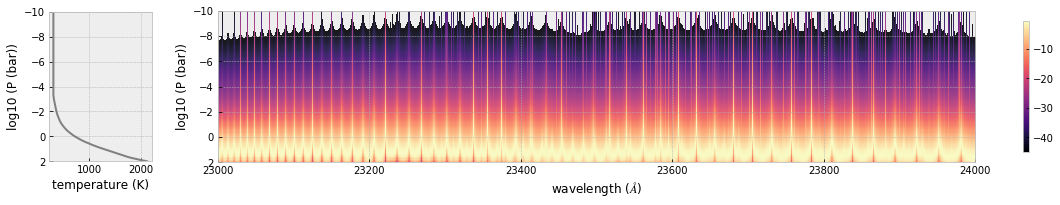

In [50]:
#contribution function
plotcf(nus,dtauM,Tarr,Parr,dParr,unit="AA") #tau

In [51]:
hcperk=1.4387773538277202
def test(nus,Tarr):
    return nus**3/(np.exp(hcperk*nus/Tarr[:,None])-1.0)

tau=np.cumsum(dtauM,axis=0)
#cf=np.exp(-tau)*dtauM*Parr[:,None]/dParr[:,None]

def testcf(nus,Tarr,Parr,dParr):
    return np.exp(-tau)*dtauM*Parr[:,None]/dParr[:,None]

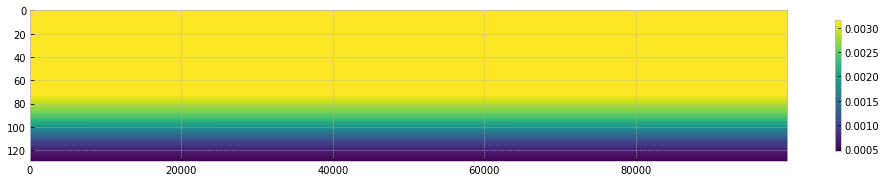

In [52]:
arr=test(nus,Tarr)
mask=(arr==0.0)
arr[mask]=None
fig=plt.figure(figsize=(20,3))
ax=plt.subplot2grid((1, 20), (0, 3),colspan=18)
#c=ax.imshow(np.log10(arr))
c=ax.imshow(np.ones_like(nus)/Tarr[:,None])
plt.colorbar(c,shrink=0.8)
ax.set_aspect(0.2/ax.get_data_ratio())

In [53]:
#np.min(arr),np.min(ccf)

In [54]:
ccf=testcf(nus,Tarr,Parr,dParr)

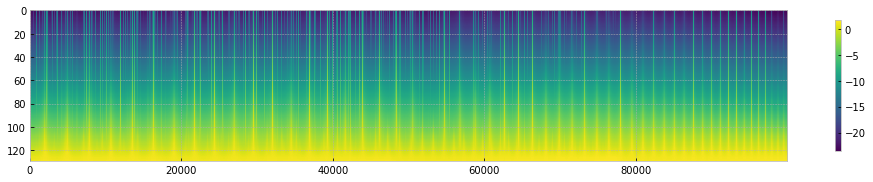

In [55]:
#def testcf(nus,Tarr,Parr,dParr):
#    return np.exp(-tau)*dtauM*Parr[:,None]/dParr[:,None]
def testcf(nus,Tarr,Parr,dParr):
    return dtauM*Parr[:,None]/dParr[:,None]
fig=plt.figure(figsize=(20,3))
ax=plt.subplot2grid((1, 20), (0, 3),colspan=18)
c=ax.imshow(np.log10(testcf(nus,Tarr,Parr,dParr)))
plt.colorbar(c,shrink=0.8)
ax.set_aspect(0.2/ax.get_data_ratio())

/home/kawahara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


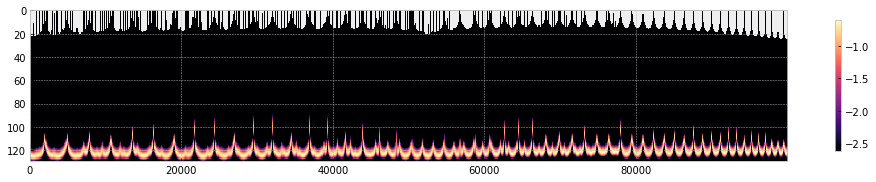

In [56]:
#img=np.log10(np.exp(-np.float64(tau))*\
#                     np.float64(dtauM*Parr[:,None]/dParr[:,None])\
#                     *nus**3/(np.exp(hcperk*nus/Tarr[:,None])-1.0))
cf=np.exp(-np.float64(tau))*np.float64(dtauM)\
             *np.float64(dtauM*Parr[:,None]/dParr[:,None])\
                     *nus**3/(np.exp(hcperk*nus/Tarr[:,None])-1.0)

cf=np.exp(-tau)*dtauM\
             *(dtauM*Parr[:,None]/dParr[:,None])\
                     *nus**3/(np.exp(hcperk*nus/Tarr[:,None])-1.0)
img=np.log10(cf/np.sum(cf,axis=0))
#img=(cf/np.sum(cf,axis=0))
#img=np.log10(cf)
fig=plt.figure(figsize=(20,3))
ax=plt.subplot2grid((1, 20), (0, 3),colspan=18)
c=ax.imshow(img,vmin=np.max(img)-2.0,cmap="magma")
#c=ax.imshow(img,cmap="magma")
plt.colorbar(c,shrink=0.8)
ax.set_aspect(0.2/ax.get_data_ratio())

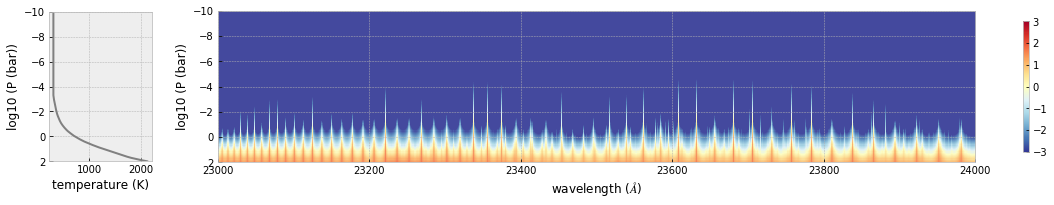

In [57]:
#plotdtauM(nus,dtauM,Tarr,Parr,unit="um") #delta tau
plottau(nus,dtauM,Tarr,Parr,unit="AA") #tau
plt.savefig("../../documents/figures/plottau.png")

In [63]:


ccgs=(speed_of_light*1.e2)
Fx0n,dtauM=rtFn(xsm)
Fx0,dtauM=rtF(xsm)

In [59]:
np.shape(mdbCO.isoid),np.shape(xsm)

((30876,), (130, 100000))

/home/kawahara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/home/kawahara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


(8.471447875798576e-12, 0.001)

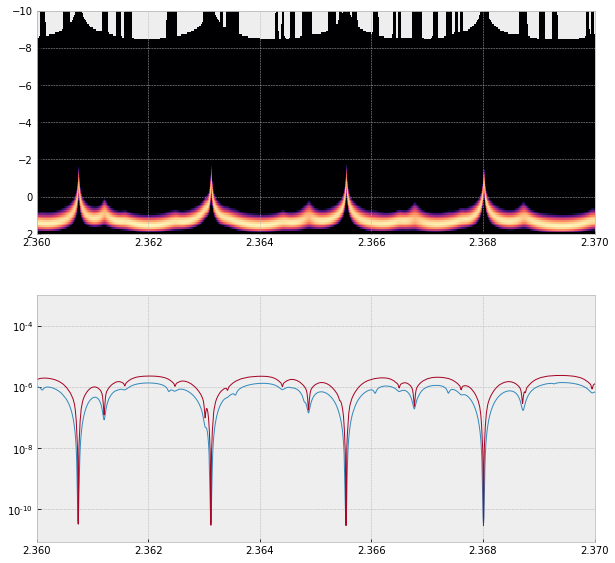

In [64]:
img=np.log10(cf/np.sum(cf,axis=0))
#img=(cf/np.sum(cf,axis=0))
#img=np.log10(cf)
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(211)
c=ax.imshow(img[:,::-1],vmin=np.max(img)-2.0,cmap="magma",extent=[1.e4/nus[-1],1.e4/nus[0],np.log10(Parr[-1]),np.log10(Parr[0])])
#plt.colorbar(c,shrink=0.8)
ax.set_aspect(0.04/ax.get_data_ratio())
#plt.ylim(0,-5)
#plt.xlim(2.30,2.37)
plt.xlim(2.36,2.37)
ax=fig.add_subplot(212)
plt.plot(1.e4/nus,Fx0/ccgs,lw=1)
#plt.plot(1.e4/nus,Fx0n/ccgs,lw=1)
plt.plot(dat["WAV"],dat["VAL"],lw=1)
#plt.xlim(1.634,1.644)
plt.xlim(2.36,2.37)
#ax.set_aspect(0.6/ax.get_data_ratio())
plt.yscale("log")
plt.ylim(0.0,1.e-3)

In [492]:
np.mean(Fx0)/np.mean(dat["VAL"])

DeviceArray(1.3789901e+10, dtype=float32)

In [440]:
def check(a):
    return a[a!=a],jnp.min(a),jnp.max(a)

In [219]:
check(dParr)

(array([], dtype=float32),
 DeviceArray(2.3886303e-11, dtype=float32),
 DeviceArray(19.280823, dtype=float32))

In [109]:
check(Fx0)

(DeviceArray([], dtype=float32),
 DeviceArray(5.5258727, dtype=float32),
 DeviceArray(6.498738, dtype=float32))

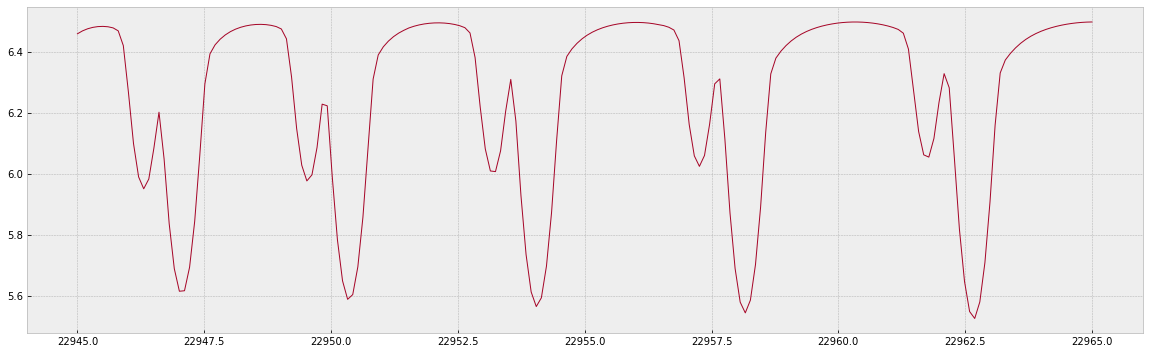

In [114]:
fig=plt.figure(figsize=(20,6.0))

plt.plot(wav[::-1],Fx0,lw=1,color="C1")
#plt.plot(wav[::-1],Fx1,lw=1,color="C2")
#plt.yscale("log")
#plt.xlim(22950,23300)
#plt.ylim(-0.1,2.6)
plt.savefig("highredCO.png")

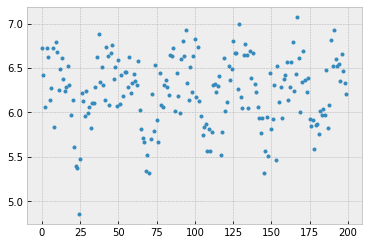

In [113]:
sigin=0.25
N=len(Fx0)
data=Fx0+np.random.normal(0,sigin,size=N)
plt.plot(data,".")

In [115]:
vgamma_hitran=jit(vmap(gamma_hitran,(0,0,0,None,None,None)))
vdoppler_sigma=jit(vmap(doppler_sigma,(None,0,None)))
vSij=jit(vmap(SijT,(0,None,None,None,0)))

In [116]:
import arviz
import numpyro.distributions as dist
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi

In [117]:
    A0=-0.57721566
    A1= 0.99999193
    A2=-0.24991055
    A3= 0.05519968
    A4=-0.00976004
    A5= 0.00107857
    B1=8.5733287401
    B2=18.059016973
    B3=8.6347608925
    B4=0.2677737343
    C1=9.5733223454
    C2=25.6329561486
    C3=21.0996530827
    C4=3.9584969228

In [118]:
#dParr[:,None]+np.zeros(np.shape(xsm))

In [119]:
#send molecular database to device
device_gamma_natural=jnp.array(gamma_natural(mdbCO.A))
device_logsij=jnp.array(mdbCO.logsij0)
device_nu_lines=jnp.array(mdbCO.nu_lines)
device_elower=jnp.array(mdbCO.elower)
device_n_air=jnp.array(mdbCO.n_air)
device_gamma_air=jnp.array(mdbCO.gamma_air)
device_gamma_self=jnp.array(mdbCO.gamma_self)
device_relative_Parr=jnp.array(Parr/Parr[-1])
device_Parr=jnp.array(Parr)
device_dParr=jnp.array(dParr[:,None]+np.zeros(np.shape(xsm)))
device_zerov=jnp.zeros(len(nus))
device_onev=jnp.ones(len(nus))

In [127]:
epsilon=1.e-20

def model(nu,y):
    A = numpyro.sample('A', dist.Uniform(0.5,1.5))
    sigma = numpyro.sample('sigma', dist.Exponential(0.3))
    #T0 = numpyro.sample('T0', dist.Uniform(1400,1600))
    nu0 = numpyro.sample('nu0', dist.Uniform(-0.3,0.3))
    #alpha=0.02 
    alpha = numpyro.sample('alpha', dist.Uniform(0.019,0.021))

    #model
    #numatrix0=make_numatrix0(nu,nu_lines)
    Tarr = 1500.*(device_relative_Parr)**alpha 
    #line computation
    SijM=vSij(Tarr,device_logsij,device_nu_lines,device_elower,qt)
    gammaLM = vgamma_hitran(device_Parr,Tarr,device_Parr,\
                            device_n_air, device_gamma_air, device_gamma_self) \
    + device_gamma_natural #uncomment if you inclide a natural width
    sigmaDM=vdoppler_sigma(device_nu_lines,Tarr,Mmol)
    #gi = piB(Tarr,nusmean)
    gi = piBarr(Tarr,nus)
    
    xsm=cxsmatrix(numatrix0-nu0,sigmaDM,gammaLM,SijM)    
    #dtauM=dParr[:,None]*(xsm)*tfac
    dtauM=device_dParr*(xsm)*tfac+epsilon
    mdtauM=1.0/(dtauM)
    mdtauM2=mdtauM*mdtauM
    mdtauM3=mdtauM*mdtauM2
    mdtauM4=mdtauM2*mdtauM2
    dtauM2=dtauM*dtauM
    dtauM3=dtauM2*dtauM
    dtauM4=dtauM2*dtauM2
    dtauM5=dtauM4*dtauM

    ep1A=-jnp.log(dtauM)+A0+A1*dtauM+A2*dtauM2+A3*dtauM3+A4*dtauM4+A5*dtauM5
    ep1A=ep1A*dtauM2
    
    ep1B=jnp.exp(-dtauM)*\
    (1.0+B1*mdtauM+B2*mdtauM2+B3*mdtauM3+B4*mdtauM4)/\
    (1.0+C1+mdtauM+C2*mdtauM2+C3*mdtauM3+C4*mdtauM4)
    ep1B=ep1B*dtauM
    
    ep=jnp.where(dtauM<=1.0, ep1A, ep1B)
    TransMx=(1.0-dtauM)*jnp.exp(-dtauM)+ep
    TransM=jnp.where(dtauM==0, 1.0, TransMx)   
    #Qv=(1.0-TransM)*gi[:,None]
    Qv=(1.0-TransM)*gi
    Qv=jnp.vstack([Qv,device_zerov])
    TransM=jnp.vstack([device_onev,TransM])
    mu=1.e2*A*(jnp.sum(Qv*jnp.cumprod(TransM,axis=0),axis=0))

    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [128]:
#nus, numatrix0 -> device?

In [129]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 100, 200

#kernel = NUTS(model)
kernel = NUTS(model,forward_mode_differentiation=True)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, nu=nus, y=data)
mcmc.print_summary()

sample: 100%|██████████| 300/300 [42:53<00:00,  5.68s/it, 31 steps of size 1.05e-01. acc. prob=0.96]  


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         A      1.00      0.00      1.00      0.99      1.00     37.54      1.00
     alpha      0.02      0.00      0.02      0.02      0.02     42.25      1.00
       nu0     -0.01      0.00     -0.01     -0.01     -0.00    245.95      1.00
     sigma      0.25      0.01      0.25      0.23      0.27    134.94      1.00

Number of divergences: 0


In [130]:
posterior_sample = mcmc.get_samples()
pred = Predictive(model,posterior_sample)
nu_ = nus
predictions = pred(rng_key_,nu=nu_,y=None)
median_mu = jnp.median(predictions["y"],axis=0)

In [131]:
hpdi_mu = hpdi(predictions["y"], 0.9)

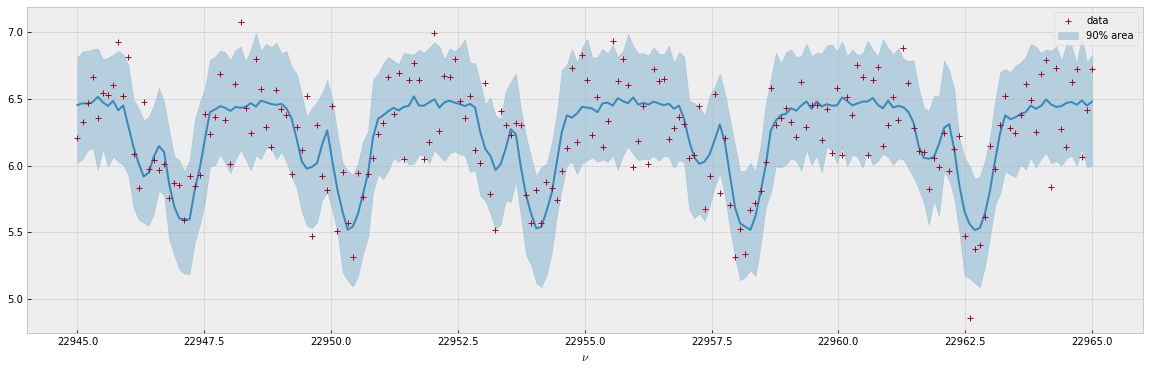

In [132]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,6.0))


#plt.plot(wav[::-1],Fx0,lw=1,color="C1",label="in")
ax.plot(wav[::-1],median_mu,color="C0")
ax.plot(wav[::-1],data,"+",color="C1",label="data")
ax.fill_between(wav[::-1], hpdi_mu[0], hpdi_mu[1], alpha=0.3, interpolate=True,color="C0",
                label="90% area")
plt.xlabel("$\\nu$")
plt.legend()
plt.savefig("../../documents/figures/mcmc_fitting_CO_emission.png")
plt.show()

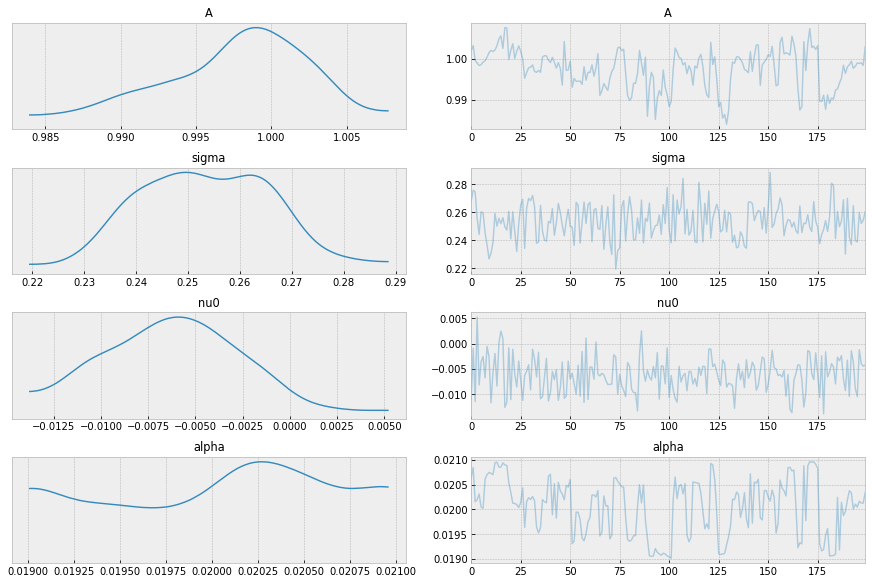

In [133]:
import arviz
arviz.plot_trace(mcmc, var_names=["A","sigma","nu0","alpha"])
plt.show()

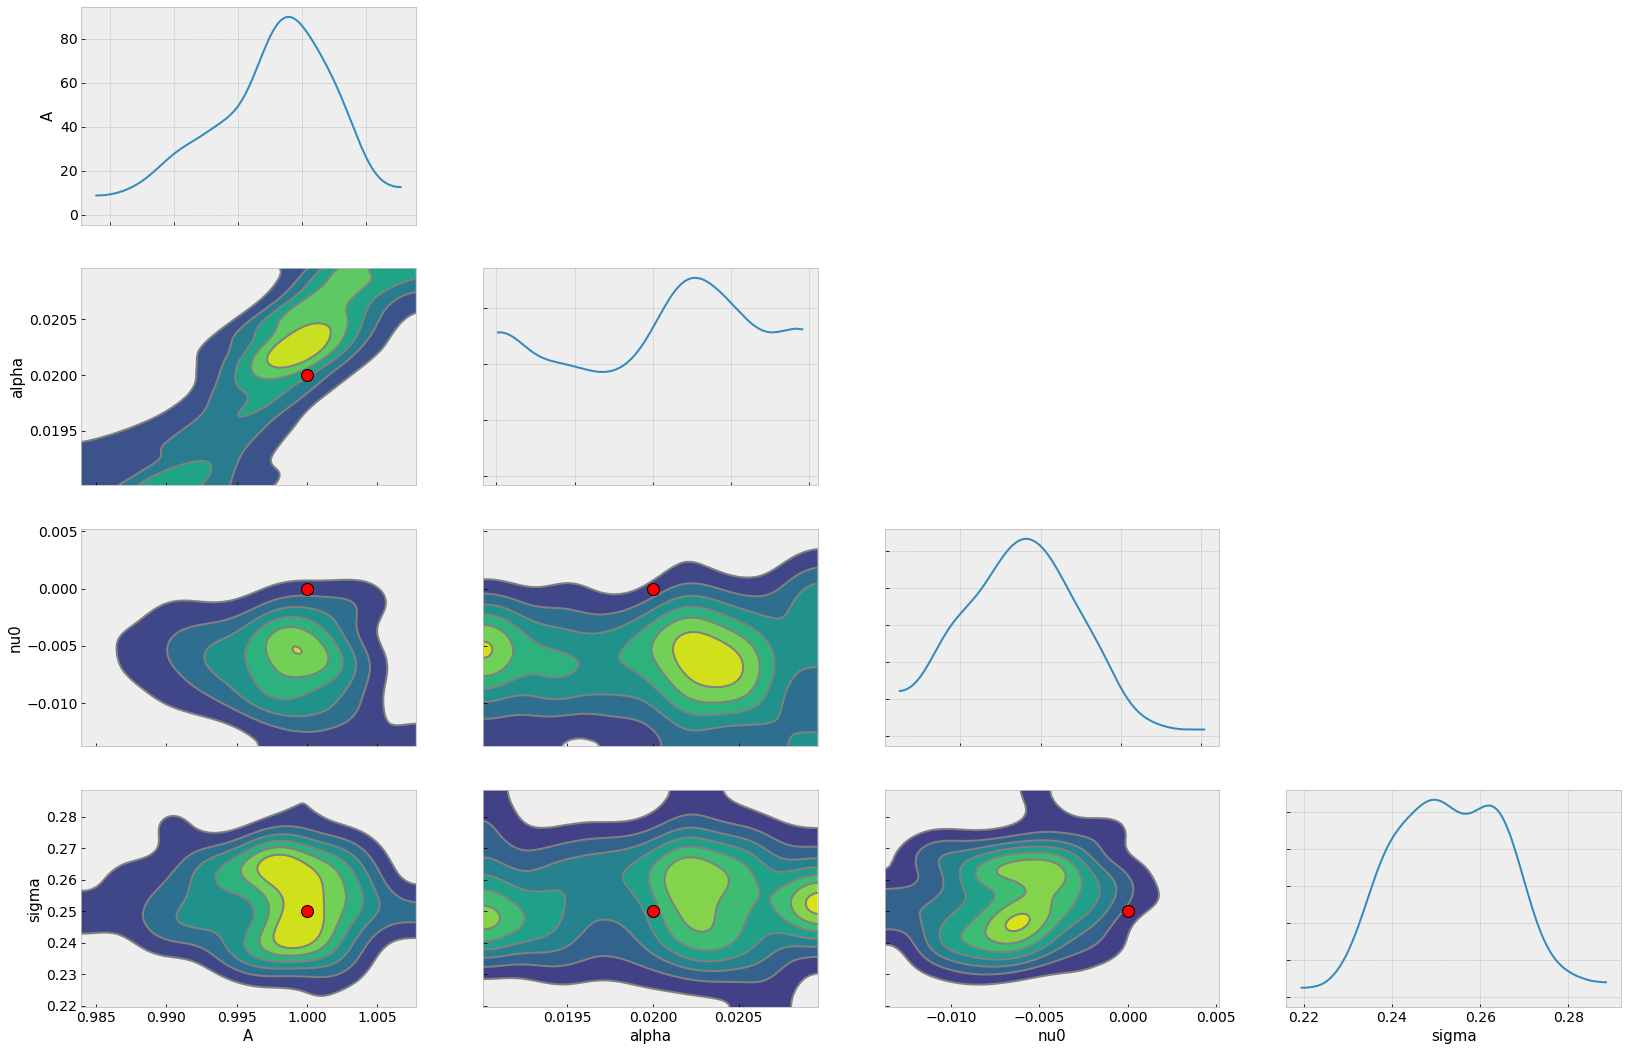

In [134]:
refs={}
refs["A"]=1.0
#refs["sD"]=sDfix
#refs["gL"]=gLfix
refs["sigma"]=sigin
refs["nu0"]=0.0
refs["alpha"]=0.02
#refs["alpha"]=-0.1
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=False,\
                marginals=True,
                reference_values=refs,
               reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 
plt.savefig("testCO.png")
plt.show()

In [45]:
sigin

1.0

## LA RT (class)

In [17]:
jaxrt=rt.JaxRT()
jaxrt.nuarr=nuarr
jaxrt.hatnufix=hatnufix
jaxrt.Sfix=Sfix
jaxrt.Parr=Parr
jaxrt.dParr=dParr
jaxrt.NP=NP
jaxrt.k=k

In [21]:
#run using flatten() and reshape()
def model(nu,y):
    #A = numpyro.sample('A', dist.Uniform(0.5,1.5))
    sD = numpyro.sample('sD', dist.Exponential(1.))
    gL = numpyro.sample('gL', dist.Exponential(1.))
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    nu0 = numpyro.sample('nu0', dist.Uniform(-5,5))
    alpha = numpyro.sample('alpha', dist.Uniform(-0.3,0.3)) #
    
    #model
    Tarr = 1000.*(Parr/Parr[0])**alpha #
    source = planck.nB(Tarr,jaxrt.numic)
    mu=jaxrt.run(nu0,sigmaD,gammaL,source)
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [20]:
#runx (using vmap)
def model(nu,y):
    #A = numpyro.sample('A', dist.Uniform(0.5,1.5))
    sD = numpyro.sample('sD', dist.Exponential(1.))
    gL = numpyro.sample('gL', dist.Exponential(1.))
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    nu0 = numpyro.sample('nu0', dist.Uniform(-5,5))
    alpha = numpyro.sample('alpha', dist.Uniform(-0.3,0.3)) #
    
    #model
    Tarr = 1000.*(Parr/Parr[0])**alpha #
    source = planck.nB(Tarr,jaxrt.numic)
    mu=jaxrt.runx(nu0,sigmaD,gammaL,source)
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [24]:
np.shape(numatrix)

(1000, 1000)

In [22]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, nu=nuarr, y=data)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [02:49<00:00, 17.74it/s, 7 steps of size 5.12e-01. acc. prob=0.91]    



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -0.10      0.00     -0.10     -0.10     -0.10   2608.95      1.00
        gL      1.06      1.04      0.75      0.01      2.38   2098.59      1.00
       nu0      0.75      0.07      0.75      0.65      0.88   2031.69      1.00
        sD      0.99      1.00      0.70      0.00      2.24   2271.31      1.00
     sigma     10.04      0.23     10.03      9.66     10.40   2238.15      1.00

Number of divergences: 0


## Note (Jan 16 2021): 
currently runx (using vmap) is ~ 2 times slower than run (using flatten() and reshape)

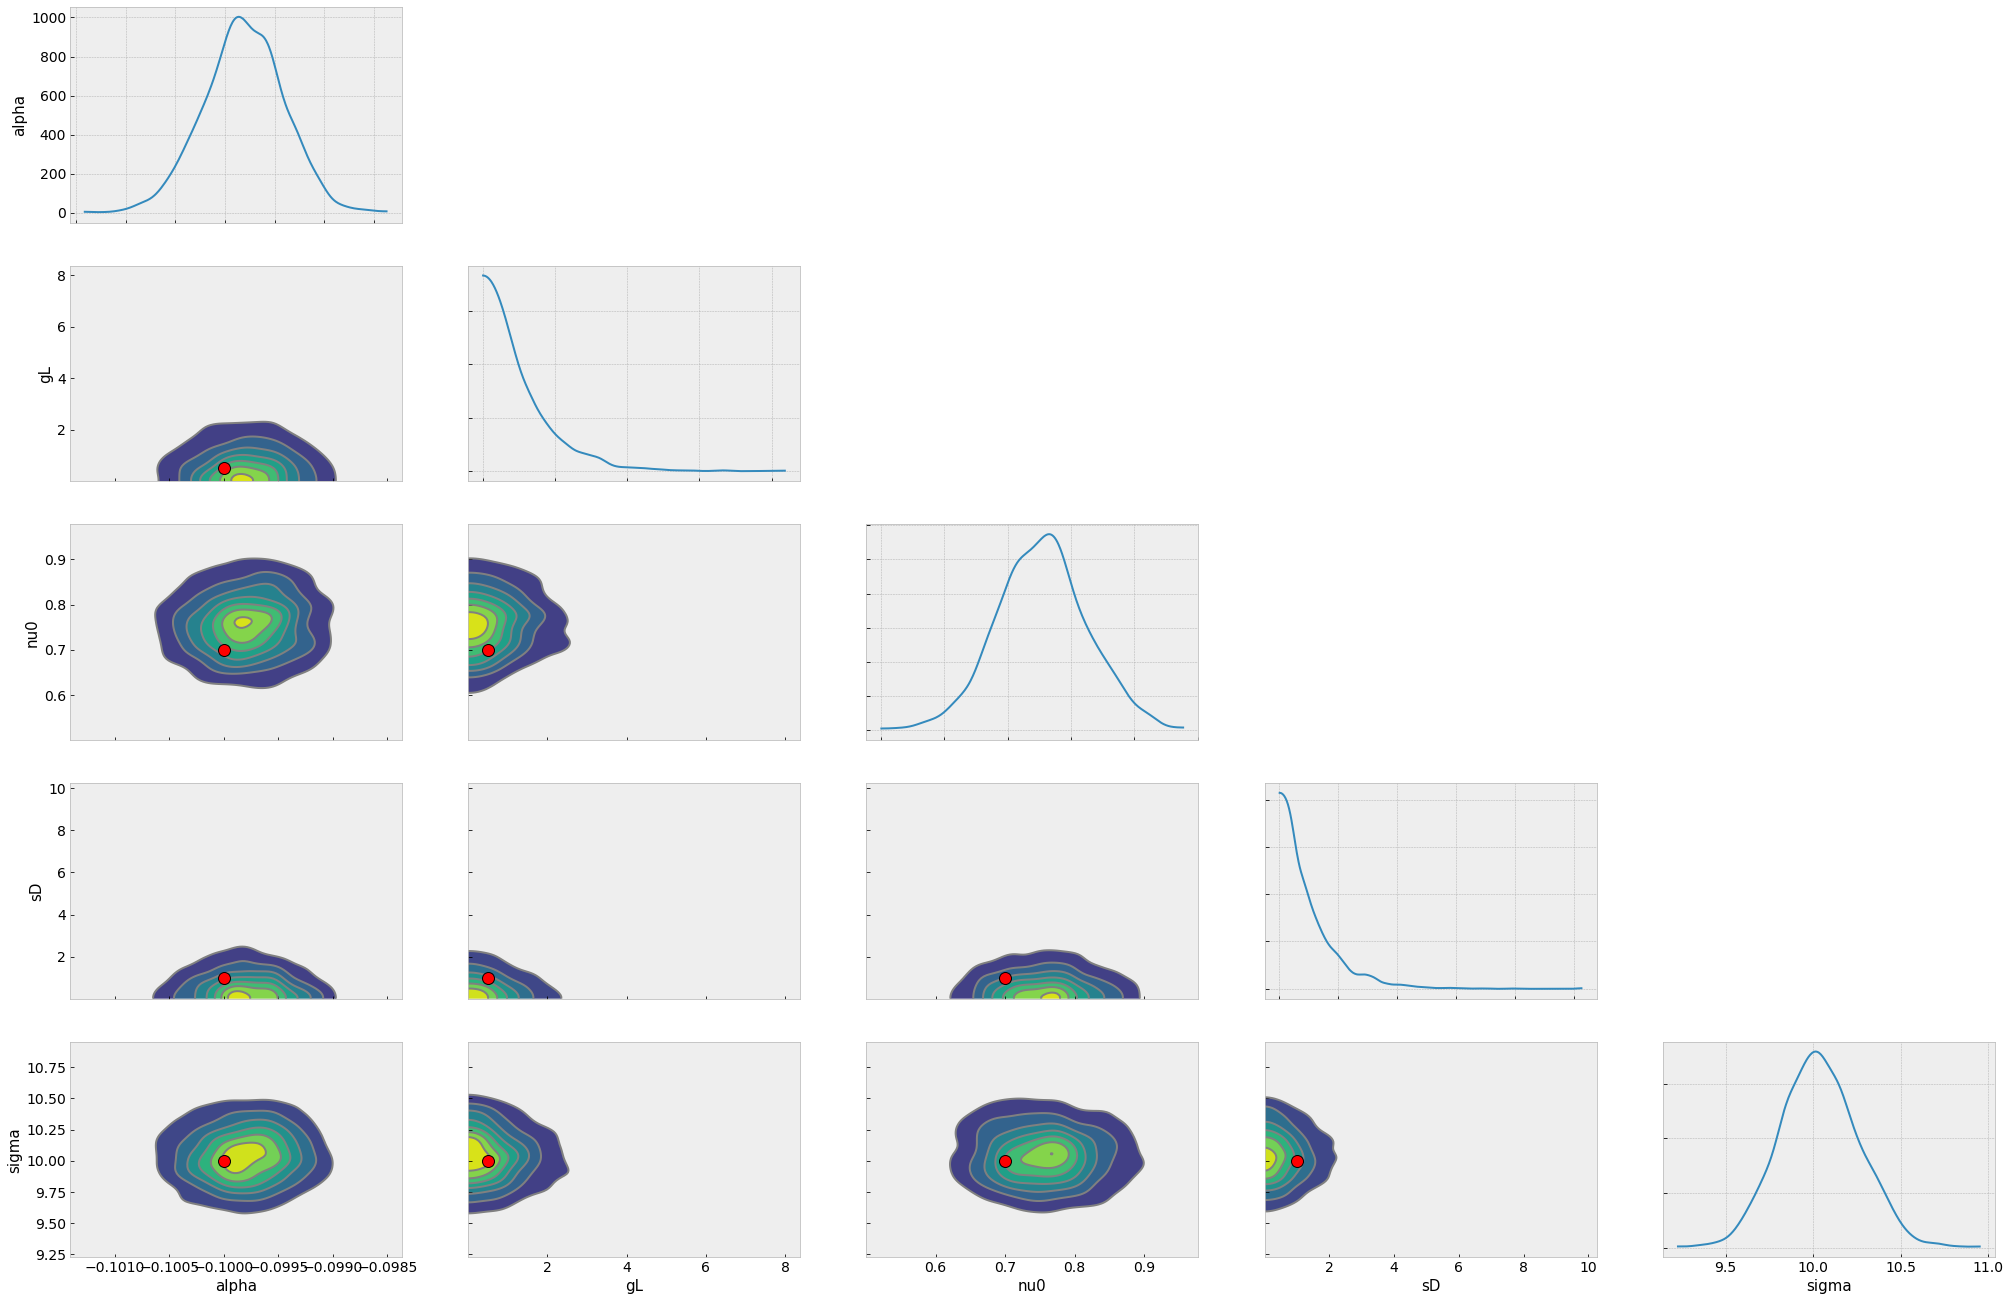

In [23]:
refs={}
#refs["A"]=Afix
refs["sD"]=sDfix
refs["gL"]=gLfix
refs["sigma"]=10.0
refs["nu0"]=nu0fix
refs["alpha"]=-0.1
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=False,\
                marginals=True,
                reference_values=refs,
               reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 
plt.show()

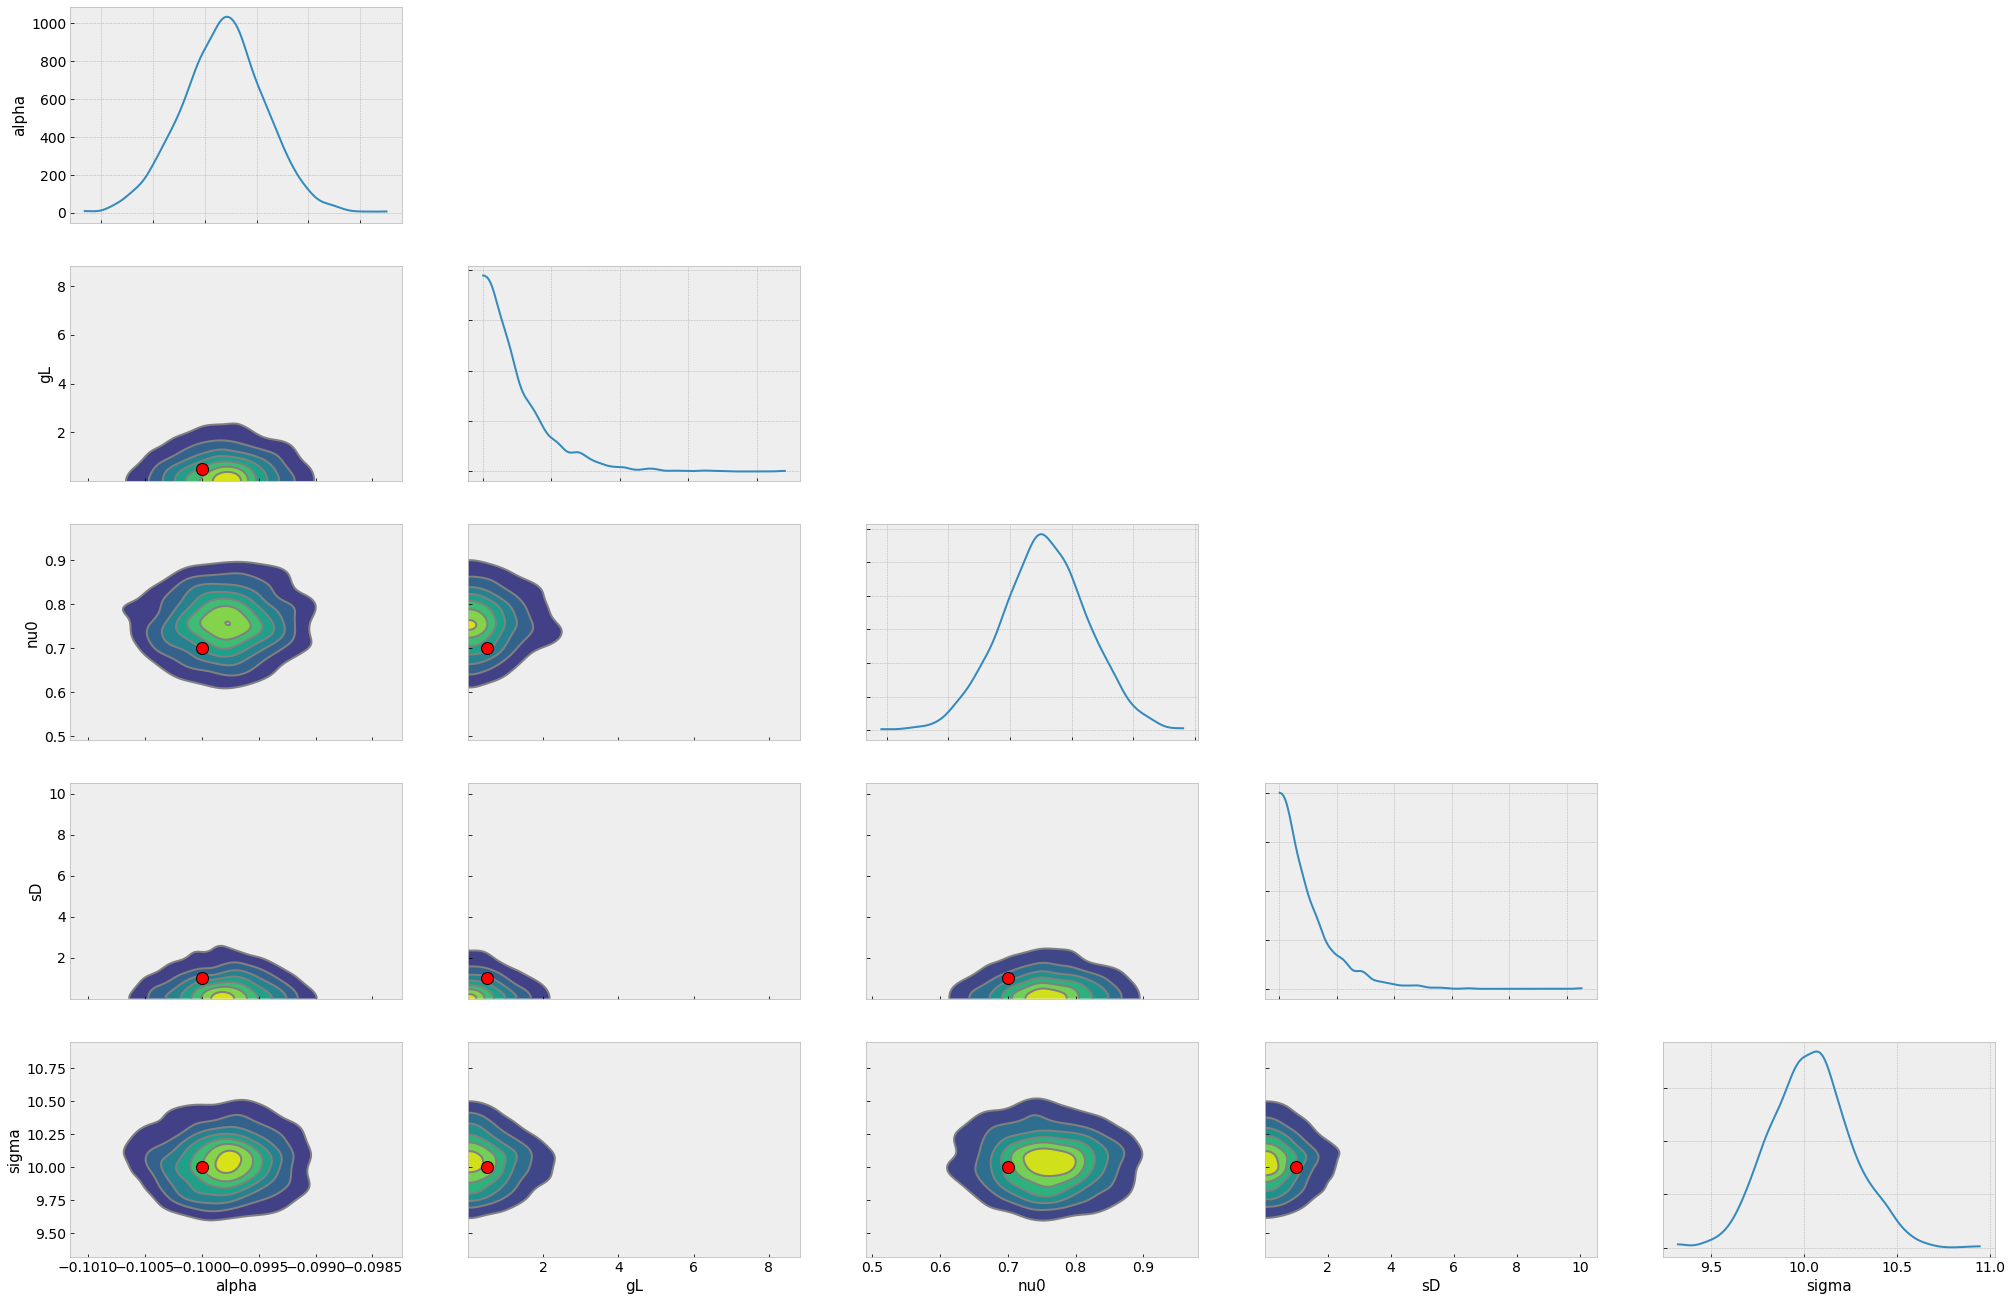

In [23]:
refs={}
#refs["A"]=Afix
refs["sD"]=sDfix
refs["gL"]=gLfix
refs["sigma"]=sigin
refs["nu0"]=nu0fix
refs["alpha"]=-0.1
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=False,\
                marginals=True,
                reference_values=refs,
               reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 
plt.show()

In [36]:
# generating predictions
# hpdi is "highest posterior density interval"
posterior_sample = mcmc.get_samples()
pred = Predictive(model,posterior_sample)
nu_ = nuarr
predictions = pred(rng_key_,nu=nu_,y=None)
median_mu = jnp.median(predictions["y"],axis=0)
hpdi_mu = hpdi(predictions["y"], 0.9)

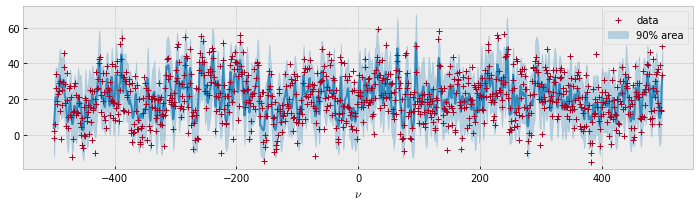

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))
ax.plot(nu_,median_mu,color="C0")
ax.plot(nuarr,data,"+",color="C1",label="data")
ax.fill_between(nu_, hpdi_mu[0], hpdi_mu[1], alpha=0.3, interpolate=True,color="C0",
                label="90% area")
plt.xlabel("$\\nu$")
plt.legend()
plt.savefig("../../documents/figures/mcmc_fitting_emission.png")
plt.show()

## Layer scan

In [9]:
jaxrt=rt.JaxRT()
jaxrt.nuarr=nuarr
jaxrt.hatnufix=hatnufix
jaxrt.Sfix=Sfix
jaxrt.Parr=Parr
jaxrt.NP=NP
jaxrt.k=k

In [10]:
numic=0.5
F0=jnp.ones(len(nuarr))*planck.nB(Tarr[0],numic)
init=[F0,Parr[0],0.7,1.0,0.5]
jaxrt.Tarr=Tarr
%timeit jaxrt.layerscan(init)

2.93 ms ± 599 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


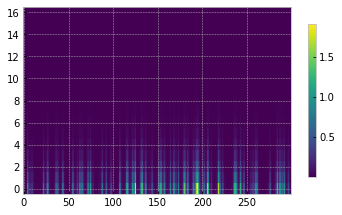

In [11]:
F0=jnp.zeros(len(nuarr))
init=[F0,Parr[0],0.7,1.0,0.5]
FP,tauarr=scan(jaxrt.add_layer,init,Tarr.T,NP)

fig=plt.figure()
ax=fig.add_subplot(111)
c=ax.imshow(tauarr)
plt.colorbar(c,shrink=0.7)
ax.set_aspect(0.7/ax.get_data_ratio())
plt.gca().invert_yaxis()

In [12]:
from jax import grad
F0=jnp.zeros(len(nuarr))
#F0=0.0
init=[F0,Parr[0],0.7,1.0,0.5]
#scan(add_layer,init,Tarr,NP)

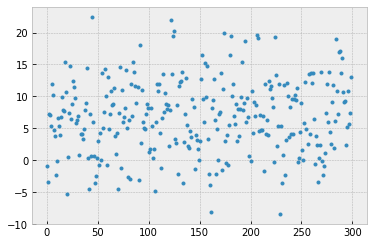

In [16]:
@jit
def g(xs):
    """
    Params: 
      xs: free parameters
    """
    Tarr=xs
    numic=0.5
    F0=jnp.ones(len(nuarr))*planck.nB(Tarr[0],numic)
    #F0=0.0
    init=[F0,Parr[0],0.7,1.0,0.5]
    FP,null=scan(jaxrt.add_layer,init,Tarr,NP)
    return FP[0]*3.e4

sigin=5.0
data=g(Tarr)+np.random.normal(0,sigin,size=N)
plt.plot(data,".")

In [17]:
#jaxrt.Tarr=Tarr

#probabilistic model using numpyro
def model(nu,y):
    #A = numpyro.sample('A', dist.Uniform(0.5,1.5))
    sD = numpyro.sample('sD', dist.Exponential(1.))
    gL = numpyro.sample('gL', dist.Exponential(1.))
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    nu0 = numpyro.sample('nu0', dist.Uniform(-5,5))
    numic=0.5
    nuarr=nu
    F0=jnp.ones(len(nuarr))*planck.nB(Tarr[0],numic)
    init=[F0,Parr[0],nu0,sD,gL]
    jaxrt.Tarr=Tarr
    mu=jaxrt.layerscan(init)
    numpyro.sample('y', dist.Normal(mu, sigma), obs=y)

In [18]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, nu=nuarr, y=data)
mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [13:50<00:00,  2.94it/s, 15 steps of size 3.07e-01. acc. prob=0.90]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        gL      0.76      0.37      0.75      0.18      1.38    665.32      1.00
       nu0      0.47      0.21      0.48      0.13      0.81   1239.00      1.00
        sD      1.04      0.43      1.05      0.24      1.65    645.96      1.00
     sigma      4.88      0.20      4.87      4.55      5.19   1361.18      1.00

Number of divergences: 57


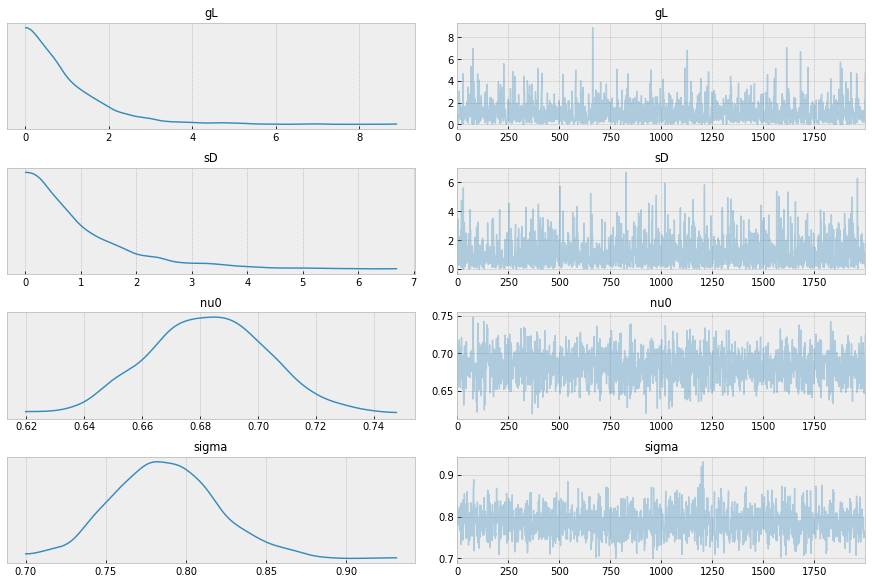

In [22]:
import arviz
arviz.plot_trace(mcmc, var_names=["gL", "sD","nu0","sigma"])
plt.show()

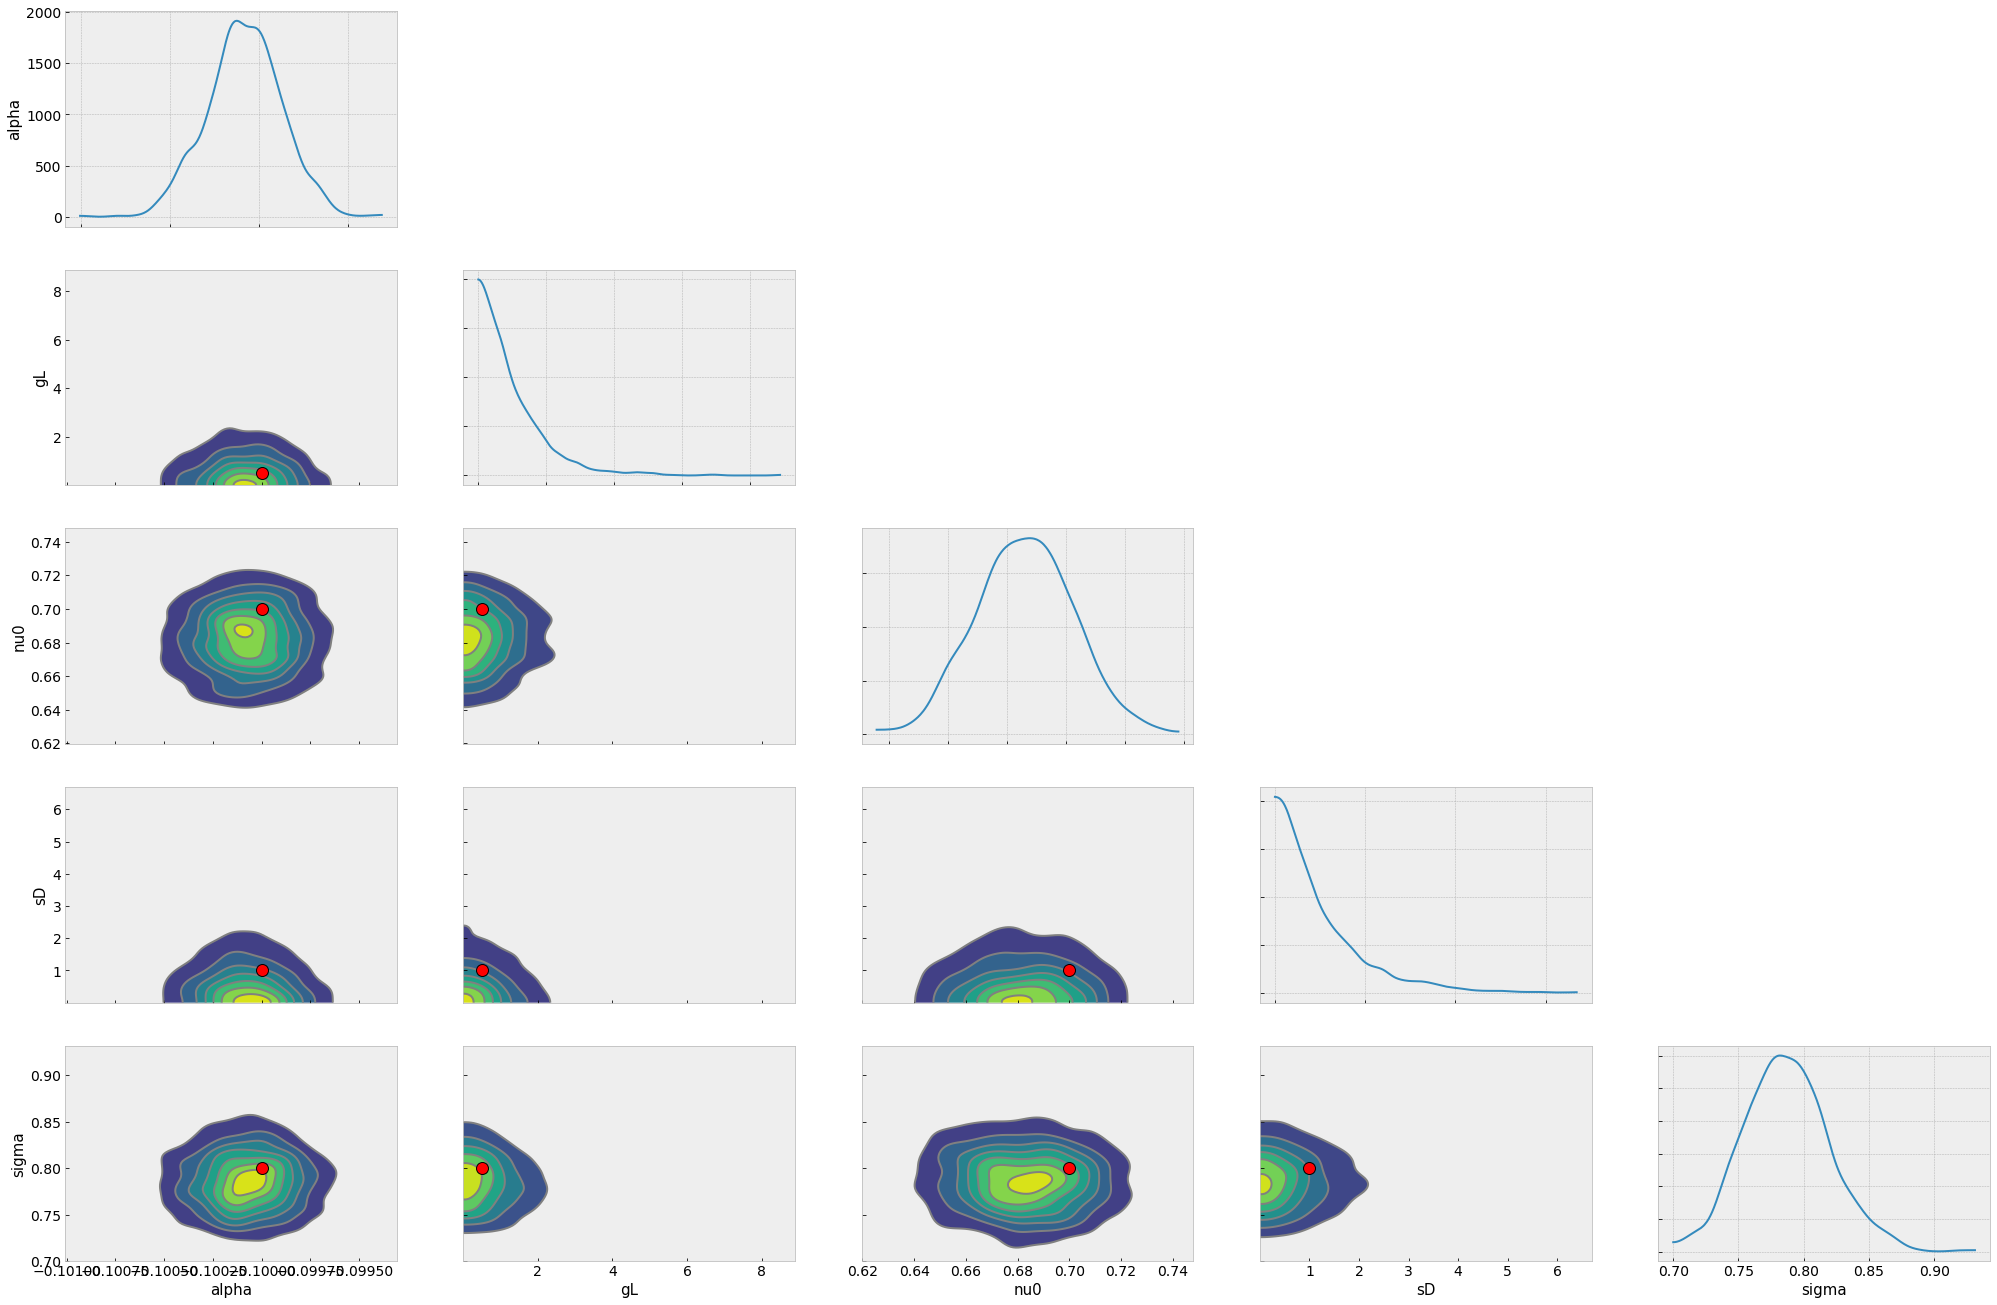

In [24]:
refs={}
#refs["A"]=Afix
refs["sD"]=sDfix
refs["gL"]=gLfix
refs["sigma"]=sigin
refs["nu0"]=nu0fix
refs["alpha"]=-0.1
arviz.plot_pair(arviz.from_numpyro(mcmc),kind='kde',divergences=False,\
                marginals=True,
                reference_values=refs,
               reference_values_kwargs={'color':"red", "marker":"o", "markersize":12}) 
plt.show()

In [25]:
# generating predictions
# hpdi is "highest posterior density interval"
posterior_sample = mcmc.get_samples()
pred = Predictive(model,posterior_sample)
nu_ = nuarr
predictions = pred(rng_key_,nu=nu_,y=None)
median_mu = jnp.median(predictions["y"],axis=0)
hpdi_mu = hpdi(predictions["y"], 0.9)

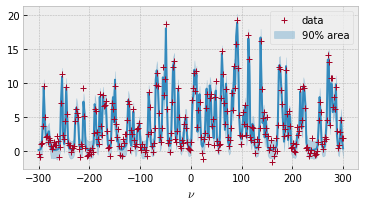

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
ax.plot(nu_,median_mu,color="C0")
ax.plot(nuarr,data,"+",color="C1",label="data")
ax.fill_between(nu_, hpdi_mu[0], hpdi_mu[1], alpha=0.3, interpolate=True,color="C0",
                label="90% area")
plt.xlabel("$\\nu$")
plt.legend()
plt.savefig("../../documents/figures/mcmc_fitting_emission.png")
plt.show()